In [1]:
# 导入相关包
import os
import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 导入预训练CNN
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import json
import jieba # ! pip install jieba
import tqdm

2022-09-08 22:49:54.624855: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# 打印版本
tf.__version__

'2.5.0'

In [3]:

# 图片地址
IMAGES_PATH = "./ai_challenger_caption_validation_20170910/caption_validation_images_20170910/"

# 目标大小
IMAGE_SIZE = (299, 299)

# 词汇量大小
VOCAB_SIZE = 10000

# 输出句子单词长度
SEQ_LENGTH = 25

# 特征向量长度
EMBED_DIM = 512

# 输出层维度大小
FF_DIM = 512

# 参数
BATCH_SIZE = 64
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

In [4]:
# 准备数据集

In [5]:
stra = '一个双手握拳的运动员跪在平坦的运动场上'

In [6]:
token  = [i for i in jieba.cut(stra)]

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.809 seconds.
Prefix dict has been built successfully.


In [7]:
len(token)

11

In [8]:
" ".join(token)

'一个 双手 握拳 的 运动员 跪 在 平坦 的 运动场 上'

In [9]:
'一个' in token

True

In [10]:
token_len = []

def load_captions_json(filename):
    
    caption_mapping = {}
    text_data = []
    images_to_skip = set()

    with open(filename) as f:
        # 读取json文件
        json_data = json.load(f)
        # 遍历
        for item in tqdm.tqdm(json_data):
            # 文件名
            img_name = item['image_id']
            img_name = os.path.join(IMAGES_PATH, img_name.strip())
            # 遍历5个标注
            for caption in item['caption']:
            
                # 分词
                tokens =[word for word in jieba.cut(caption)]
             
                # 根据tokens构造caption（打空格）
                caption = " ".join(tokens)   
                
                # 统计一下长度
                token_len.append(len(tokens))
                
                if len(tokens) < 3 or len(tokens) > SEQ_LENGTH:
                    images_to_skip.add(img_name)
                    continue

                # 如果文件名以jpg结尾，且标注不在images_to_skip中
                if img_name.endswith("jpg") and img_name not in images_to_skip:
                    # 增加开始和结束token
                    caption = "<start> " + caption.strip() + " <end>"
                    text_data.append(caption)

                    if img_name in caption_mapping:
                        # 追加
                        caption_mapping[img_name].append(caption)
                    else:
                        # 初始化
                        caption_mapping[img_name] = [caption]
                        
        # 如果文件名在images_to_skip中，则将caption_mapping中的元素删除掉
        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]
                
        return caption_mapping, text_data

In [11]:
# 加载数据
captions_mapping, text_data = load_captions_json("./ai_challenger_caption_validation_20170910/caption_validation_annotations_20170910.json")

100%|██████████| 30000/30000 [00:20<00:00, 1476.20it/s]


In [12]:
# np.array(token_len).mean()

In [13]:
captions_mapping

{'./ai_challenger_caption_validation_20170910/caption_validation_images_20170910/3cd32bef87ed98572bac868418521852ac3f6a70.jpg': ['<start> 一个 双臂 抬起 的 运动员 跪 在 绿茵茵 的 球场上 <end>',
  '<start> 一个 抬着 双臂 的 运动员 跪 在 足球场 上 <end>',
  '<start> 一个 双手 握拳 的 男人 跪 在 绿茵茵 的 足球场 上 <end>',
  '<start> 一个 抬起 双手 的 男人 跪 在 碧绿 的 球场上 <end>',
  '<start> 一个 双手 握拳 的 运动员 跪 在 平坦 的 运动场 上 <end>'],
 './ai_challenger_caption_validation_20170910/caption_validation_images_20170910/fb36d921dcd9184bdd4659864fe7f3cff47accf5.jpg': ['<start> 房间 里 一个 右手 放在 嘴角 的 女人 和 一个 戴着 眼镜 的 男人 在 研究 仪器 <end>',
  '<start> 一个 披 着 长发 的 女人 和 一个 戴着 眼镜 的 男人 站 在 室内 的 桌子 旁 <end>',
  '<start> 室内 有 一个 戴着 眼镜 的 男人 在 向 一个 抬起 右手 的 女人 展示 东西 <end>',
  '<start> 房间 里 有 一个 左手 放在 盒子 上 的 男人 在 给 一个 右手 食指 放在 嘴边 的 女人 展示 东西 <end>',
  '<start> 一个 右手 放在 嘴边 的 女人 和 一个 戴着 眼镜 的 男人 站 在 房间 里 <end>'],
 './ai_challenger_caption_validation_20170910/caption_validation_images_20170910/b573129c61c37aced9c1ede434ec150cbcfdfac5.jpg': ['<start> 一个 穿着 运动服 的 男人 单膝 跪 在 球场上 <end>',
  '<start

In [14]:
text_data

['<start> 一个 双臂 抬起 的 运动员 跪 在 绿茵茵 的 球场上 <end>',
 '<start> 一个 抬着 双臂 的 运动员 跪 在 足球场 上 <end>',
 '<start> 一个 双手 握拳 的 男人 跪 在 绿茵茵 的 足球场 上 <end>',
 '<start> 一个 抬起 双手 的 男人 跪 在 碧绿 的 球场上 <end>',
 '<start> 一个 双手 握拳 的 运动员 跪 在 平坦 的 运动场 上 <end>',
 '<start> 房间 里 一个 右手 放在 嘴角 的 女人 和 一个 戴着 眼镜 的 男人 在 研究 仪器 <end>',
 '<start> 一个 披 着 长发 的 女人 和 一个 戴着 眼镜 的 男人 站 在 室内 的 桌子 旁 <end>',
 '<start> 室内 有 一个 戴着 眼镜 的 男人 在 向 一个 抬起 右手 的 女人 展示 东西 <end>',
 '<start> 房间 里 有 一个 左手 放在 盒子 上 的 男人 在 给 一个 右手 食指 放在 嘴边 的 女人 展示 东西 <end>',
 '<start> 一个 右手 放在 嘴边 的 女人 和 一个 戴着 眼镜 的 男人 站 在 房间 里 <end>',
 '<start> 一个 穿着 运动服 的 男人 单膝 跪 在 球场上 <end>',
 '<start> 一个 穿着 运动服 的 运动员 单膝 跪 在 运动场 上 <end>',
 '<start> 一个 穿着 运动服 的 男人 摔倒 在 宽阔 的 运动场 上 <end>',
 '<start> 一个 穿着 短袖 上衣 的 男人 跪 在 运动场 上 <end>',
 '<start> 一个 穿着 白色 上衣 的 男人 单膝 跪 在 足球场 上 <end>',
 '<start> 湍急 的 河水 里 有 一群 穿着 救生衣 的 人 在 划 橡皮艇 <end>',
 '<start> 海水 里 有 一个 穿着 黑色 上衣 的 男人 和 一群 穿着 黄色 上衣 的 人 在 滑 皮艇 <end>',
 '<start> 湍急 的 河流 上 有 一群 手里 拿 着 船桨 的 人 在 划 皮艇 <end>',
 '<start> 河水 里 有 一群 身穿 救生 服 的 人 和 一个 身穿 黑

In [15]:
# captions_mapping

In [16]:

def train_val_split(caption_data, train_size=0.8):
    # 分成训练集和测试集

    # 获取所有图片的文件名
    all_images = list(caption_data.keys())
    # 打乱顺序
    np.random.shuffle(all_images)

    # 分成训练集和测试集
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    return training_data, validation_data




In [17]:
train_data, valid_data = train_val_split(captions_mapping)

In [18]:
len(train_data),len(valid_data)

(23896, 5975)

In [19]:
# 文本向量化
# 将原始文本中词汇变成类似one hot encoding的索引

In [20]:
# 文本向量化

def custom_standardization(input_string):
    # 全部转为小写
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")



strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")


vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)

vectorization.adapt(text_data)


2022-09-08 22:50:17.885237: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-09-08 22:50:17.910457: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:57:00.0 name: NVIDIA RTX A5000 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 64 deviceMemorySize: 23.69GiB deviceMemoryBandwidth: 715.34GiB/s
2022-09-08 22:50:17.910485: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-09-08 22:50:17.913655: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-09-08 22:50:17.913715: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-09-08 22:50:17.914851: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.

In [21]:
# 查看所有词汇
vectorization.get_vocabulary()

['',
 '[UNK]',
 '的',
 '<start>',
 '<end>',
 '一个',
 '在',
 '上',
 '男人',
 '着',
 '穿着',
 '女人',
 '有',
 '两个',
 '站',
 '人',
 '里',
 '拿',
 '戴着',
 '右手',
 '双手',
 '球场上',
 '走',
 '左手',
 '道路',
 '和',
 '坐在',
 '运动场',
 '球衣',
 '三个',
 '旁边',
 '舞台',
 '上衣',
 '运动服',
 '房间',
 '一群',
 '旁',
 '帽子',
 '前面',
 '包',
 '踢足球',
 '黑色',
 '衣服',
 '前',
 '室内',
 '足球',
 '草地',
 '大厅',
 '运动员',
 '一位',
 '室外',
 '白色',
 '话筒',
 '裙子',
 '东西',
 '眼镜',
 '屋子里',
 '街道',
 '放在',
 '四个',
 '坐',
 '干净',
 '面带微笑',
 '深色',
 '足球场',
 '身穿',
 '平坦',
 '打',
 '孩子',
 '人旁',
 '墨镜',
 '抱',
 '抢',
 '打篮球',
 '球服',
 '明亮',
 '争抢',
 '插',
 '头发',
 '短袖',
 '抬起',
 '表演',
 '宽敞',
 '房屋',
 '手里',
 '裤子',
 '交谈',
 '桌子',
 '小孩',
 '男士',
 '衣着',
 '椅子',
 '广告牌',
 '女孩',
 '蹲',
 '房屋里',
 '背着',
 '外套',
 '不同',
 '红色',
 '西装',
 '短裤',
 '女士',
 '给',
 '各异',
 '旁有',
 '搂',
 '说话',
 '拎',
 '手机',
 '连衣裙',
 '看着',
 '绿茵茵',
 '讲话',
 '宽阔',
 '人前',
 't台',
 '、',
 '唱歌',
 '沙发',
 '穿',
 '绿油油',
 '长发',
 '整洁',
 '碧绿',
 '浅色',
 '汽车',
 '走秀',
 '展板',
 '蓝色',
 '前有',
 '奔跑',
 '男孩',
 '身前',
 '口袋',
 '叉腰',
 '红毯',
 '兜',
 '球拍',
 '高尔夫球',
 '球杆',
 '行走',
 '牵着',

In [22]:
# 测试一下，后面0代表补白
vectorization(['一个 男人 穿着 衣服 直升机 好 恩培'])

<tf.Tensor: shape=(1, 25), dtype=int64, numpy=
array([[   5,    8,   10,   42, 2804, 8118,    1,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0]])>

In [23]:
# 制作数据集

In [24]:

def decode_and_resize(img_path):
    # 读取图片，并缩放
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)


def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(len(images))
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset

# 制作数据集
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))
valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))


In [25]:
# train_data.keys()

In [26]:
valid_dataset

<PrefetchDataset shapes: ((None, 299, 299, 3), (None, None, 25)), types: (tf.float32, tf.int64)>

In [27]:
vocab = np.array(vectorization.get_vocabulary())

In [28]:
# vocab[[1,2,3,4]]

In [29]:
# vocab[[1,2,3]]

2022-09-08 22:50:50.526665: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-08 22:50:50.532674: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2000000000 Hz


[['<start>' '绿油油' '的' '球场上' '三个' '男人' '的' '中间' '走' '着' '一个' '右手' '比' '着'
  '剪刀手' '的' '男人' '<end>' '' '' '' '' '' '' '']
 ['<start>' '一个' '人' '的' '前面' '有' '三个' '穿着' '短裤' '的' '球员' '在' '宽阔' '的'
  '球场上' '踢足球' '<end>' '' '' '' '' '' '' '' '']
 ['<start>' '两个' '人前' '有' '两个' '穿着' '短袖' '上衣' '的' '男人' '在' '运动场' '上'
  '踢足球' '<end>' '' '' '' '' '' '' '' '' '' '']
 ['<start>' '四个' '穿着' '运动服' '的' '男人' '在' '翠绿' '的' '草地' '上' '踢足球' '<end>'
  '' '' '' '' '' '' '' '' '' '' '' '']
 ['<start>' '四个' '穿着' '运动衣' '的' '人' '在' '平坦' '的' '运动场' '上' '踢足球' '<end>'
  '' '' '' '' '' '' '' '' '' '' '' '']]


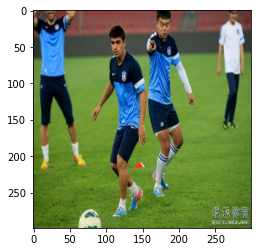

In [30]:
for i in train_dataset:
    # 获取图片
    img = i[0][0].numpy().astype('int')
    # 获取标注
    caption = i[1][0].numpy()
    # 显示
    plt.imshow(img)
    # 解码
    print(vocab[caption])
    
    
    break

In [31]:
# 构建模型
# 1.CNN提取图片特征
# 2.transformer encoder：输入图片特征，得到新的表达方式
# 3.transformer decoder：将encoder的输出、以及文本标注的输入作为输入，然后输出标签

In [32]:
def get_cnn_model():
    # CNN模型
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet",
    )
    # 冻住特征提取层
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model

In [33]:
cnn_model = get_cnn_model()

In [34]:
cnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 299, 299, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 299, 299, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [35]:
# 模拟图片测试一下
cnn_test_input = tf.random.normal([64, 299,299,3])
# 输入网络
cnn_test_output = cnn_model(cnn_test_input, training=False)

2022-09-08 22:50:53.398075: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-09-08 22:50:54.299279: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2022-09-08 22:50:55.472615: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-09-08 22:50:56.210023: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-09-08 22:50:56.216809: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [36]:
# 查看大小
cnn_test_output.shape

TensorShape([64, 100, 1280])

In [37]:
class TransformerEncoderBlock(layers.Layer):
    # transformer encoder网络：https://www.youtube.com/watch?v=n9TlOhRjYoc
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__()
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        # layer norm
        inputs = self.layernorm_1(inputs)
        
        inputs = self.dense_1(inputs)
        # multi head attention
        # training：布尔值，表示推理还是训练（是否使用 dropout）
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        # residual然后再layer norm
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1

In [38]:
# 测试一下
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)

In [39]:
# 输入网络
encoder_test_output = encoder(cnn_test_output, training=False)

In [40]:
encoder_test_output.shape

TensorShape([64, 100, 512])

In [41]:
class PositionalEmbedding(layers.Layer):
    # 位置编码
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__()
        '''
        embedding用法：https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work
        input_dim：词汇数量；output_dim：特征向量大小
        将下图左列转为右边
        +------------+------------+
        |   index    |  Embedding |
        +------------+------------+
        |     0      | [1.2, 3.1] |
        |     1      | [0.1, 4.2] |
        |     2      | [1.0, 3.1] |
        |     3      | [0.3, 2.1] |
        |     4      | [2.2, 1.4] |
        |     5      | [0.7, 1.7] |
        |     6      | [4.1, 2.0] |
        +------------+------------+
        '''
        # token embedding：长度为vocab_size，特征向量为：embed_dim
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        # position_embeddings：
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

        # 512开根号：22.627416998：https://jalammar.github.io/illustrated-transformer/
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))


    def call(self, inputs):
        # 获取caption长度，这里是24个（前24个单词）
        length = tf.shape(inputs)[-1]

        # 生成0~length的数字
        positions = tf.range(start=0, limit=length, delta=1)
        
        # 输入的句子index转为embedding特征，大小：(N, 24, 512)
        embedded_tokens = self.token_embeddings(inputs)
        # 乘以22.62
        embedded_tokens = embedded_tokens * self.embed_scale
        
        # 位置编码，大小：(24, 512)
        embedded_positions = self.position_embeddings(positions)
        
        # 加和 返回
        return embedded_tokens + embedded_positions


In [42]:
# 测试模型
test_embedding_model = PositionalEmbedding(embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE)

In [43]:
# 测试输入，选择一个batch中的第一个句子（一共有5个）
for i in train_dataset:
    # print(i[1].shape)
    
    # 获取测试标签,大小：(64, 24)，前24个词
    caption = i[1][:,0,:-1]
    print(caption.shape)
    
    # 传入模型
    positional_output = test_embedding_model(caption)
    # 打印结果的大小
    print(positional_output.shape)
    
    
    break

(64, 24)
(64, 24, 512)


In [44]:
# 可以看到，将长度为24的单词变为512的embedding向量

In [45]:
# 解码器
class TransformerDecoderBlock(layers.Layer):
    
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__()
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        
        # 位置编码
        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
        )
        
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        
        # 获取位置编码，(N,24) --> (N,24,512)
        inputs = self.embedding(inputs)
        
        '''
        shape:(64,24,24)
        64个一模一样，大小为(24, 24)的mask
        
        [[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
         [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
         [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
         [1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
         [1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
         [1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
         [1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
         [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
         [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
         [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
         [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
         [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
         [1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
         [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
         [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
         [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
         [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
         [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
         [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
         [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0]
         [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0]
         [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0]
         [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
         [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
         
        '''
        causal_mask = self.get_causal_attention_mask(inputs)
        
        
        '''
        mask (64,24) --> padding_mask (64, 24, 1)

        64个大小为(24, 1)的mask

        [[1][1][1]...[0][0][0][0][0]]

        '''
        padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)

        '''
        mask (64,24) --> combined_mask (64, 1, 24)            
        64个大小为(1, 24)的mask
        [[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]

        '''
        combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)


        '''
        在combined_mask与causal_mask选择最小值，大小(64, 24, 24)
        64个不再一模一样，大小为(24, 24)的mask

        [[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
         [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
         [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
         [1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
         [1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
         [1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
         [1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
         [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
         [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
         [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
         [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
         [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
         [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
         [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
         [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
         [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
         [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
         [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
         [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
         [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
         [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
         [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
         [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
         [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]

        '''

        combined_mask = tf.minimum(combined_mask, causal_mask)
     
            
        # 第一个masked self  attention，QKV都是inputs, mask是causal mask，强制训练时只关注输出位置左侧的token，以便模型可以自回归地推断
        
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)
        

        
        # cross attention，其中K、V来自encoder，Q来自decoder前一个的attention输出，mask是padding mask，用来遮挡25个单词中补白的部分
        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        
        # 最后输出为VOCAB_SIZE大小的向量，对应位置的大小为概率，可以查索引来获取相应原单词
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        '''
        causal: 因果关系mask
        '''
        # (N,24,512)
        input_shape = tf.shape(inputs)
        # 分别为N，24
        batch_size, sequence_length = input_shape[0], input_shape[1]

        #范围0~24的列表，变成大小(24, 1)的数组
        i = tf.range(sequence_length)[:, tf.newaxis]
        #范围0~24的列表
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        
        # 大小为(1, 24, 24)
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        
        scale = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        # (1, 24, 24)铺成(64, 24, 24)
        result = tf.tile(mask, scale)

        return result

In [46]:
# 测试模型
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)

In [47]:
# decoder.summary()

In [48]:
# 测试输入

for i in train_dataset:
    # 前0~ -1（24）个单词（去尾）
    batch_seq_inp = i[1][:,0,:-1]
    # print(batch_seq_inp.shape)

    # 前1~ 个（24）个单词（掐头），用做ground truth标注
    batch_seq_true = i[1][:,0,1:]
    # print(batch_seq_true.shape)
    
    # 将batch_seq_true中的每一个元素和0作对比，返回类似[true,true,false]形式的mask，遇到0，则会变成false，0表示字符串中长度不够25的补白部分（padding）
    mask = tf.math.not_equal(batch_seq_true, 0)
    # print(mask.shape)
    

    # 输入decoder预测的序列
    batch_seq_pred = decoder(
        batch_seq_inp, encoder_test_output, training=False, mask=mask
    )
    
    print(batch_seq_pred.shape)
    break

(64, 24, 10000)


In [49]:

# 数据增强
image_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.2),
        layers.experimental.preprocessing.RandomContrast(0.3),
    ]
)


In [50]:
class ImageCaptioningModel(keras.Model):
    def __init__(
        self, cnn_model, encoder, decoder, num_captions_per_image=5, image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        '''
        计算loss
        '''
        
        # 图片的embedding特征输入encoder,得到新的seq，大小（N,100,512）
        encoder_out = self.encoder(img_embed, training=training)
        
        # batch_seq的shape：(64, 25)
        # 前24个单词（去尾）
        batch_seq_inp = batch_seq[:, :-1]
        
        # 后24个单词（掐头），用做ground truth标注
        batch_seq_true = batch_seq[:, 1:]
        
        # mask掩码，将batch_seq_true中的每一个元素和0作对比，返回类似[true,true,false]形式的mask，遇到0，则会变成false，0表示字符串中长度不够25的补白部分（padding）
        mask = tf.math.not_equal(batch_seq_true, 0)
        
        # 输入decoder预测的序列
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        # 计算loss和acc
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        '''
        训练步骤
        '''
        # 获取图片和标注
        batch_img, batch_seq = batch_data
        # 初始化
        batch_loss = 0
        batch_acc = 0
        # 是否使用数据增强
        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 获取图片embedding特征
        img_embed = self.cnn_model(batch_img)

        # 遍历5个文本标注
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                # 计算loss和acc
                # batch_seq的shape：(64, 5, 25)
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 更新loss和acc
                batch_loss += loss
                batch_acc += acc

            # 获取所有可训练参数
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 获取梯度
            grads = tape.gradient(loss, train_vars)

            # 更新参数
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 更新
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 获取图片embedding特征
        img_embed = self.cnn_model(batch_img)

        # 遍历5个文本标注
        for i in range(self.num_captions_per_image):
            
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

In [51]:
# 模型实例化
cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

In [52]:
# encoder.shape

In [53]:

# loss
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

# 提前终止
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


# LR调节
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# 编译
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)


In [54]:

# 训练
# caption_model.fit(
#     train_dataset,
#     epochs=EPOCHS,
#     validation_data=valid_dataset,
#     callbacks=[early_stopping],
# )


In [55]:
# 加载权重
load_status = caption_model.load_weights("./my_model/checkpoint")

In [56]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())
valid_caption = list(valid_data.values())
valid_len = len(valid_images)

In [57]:
import cv2

In [58]:
# 测试
import random
def generate_caption():
    # 在测试集中随机取一张图片
    random_index = random.randrange(0,valid_len)
    sample_img = valid_images[random_index]
    sample_caption = valid_caption[random_index][0]
    # 读取图片
    sample_img = decode_and_resize(sample_img)
    img_show = sample_img.numpy().clip(0, 255).astype(np.uint8)

    plt.imshow(img_show)
    plt.axis('off')
    plt.show()
    
    # 保存
    cv2.imwrite('./img/raw.jpg',cv2.cvtColor(img_show,cv2.COLOR_RGB2BGR))
    # 获取CNN特征
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # 传给encoder
    encoded_img = caption_model.encoder(img, training=False)
    
    
    
    # 1.先提供"<start> "
    # 2.传给decoder推理，
    # 3.不断投喂给模型，直到遇到<end>停止
    # 4.如果循环次数超出句子长度，也停止
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)

        # 预测
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == " <end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    
    sample_caption = sample_caption.replace("<start> ", "")
    sample_caption = sample_caption.replace(" <end>", "").strip()
    
    
    print("预测: ", decoded_caption)
    print('真实：',sample_caption)



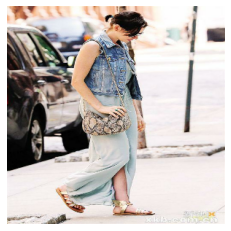

预测:  一个 戴着 墨镜 的 女人 走 在 道路 上 的 汽车 旁
真实： 一个 右肩 挎着 包 的 女人 走 在 干净 的 道路 上


In [59]:
generate_caption()

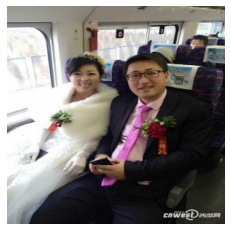

预测:  车厢 里 一个 穿着 西装 的 男人 和 一个 穿着 婚纱 的 女人 坐在 椅子 上
真实： 明亮 的 车厢 里 坐 着 一对 拿 着 手机 的 男女


In [60]:
generate_caption()

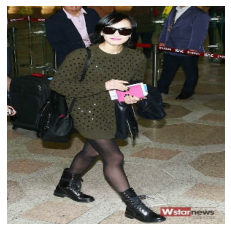

预测:  大厅 里 一个 人 的 旁边 走 着 一个 右手 拿 着 手机 的 女人 走 在 人群 前
真实： 街道 上 的 人群 旁 走 着 一个 右肩 挎包 、 左手 拿 东西 的 女人


In [61]:
generate_caption()

In [62]:
# 保存权重
# caption_model.save_weights("./my_model/checkpoint")
